In the forest fire simulation we've set up, we are modeling the spread of a wildfire through a forested area. This model is based on a cellular automaton approach, where the forest is represented as a grid of cells, each of which can be in one of three states: empty, containing a tree, or on fire. The simulation integrates real-world data for tree coverage, providing a more realistic scenario for how a fire might spread in an actual forest. Here's a breakdown of the scenario and the objectives of the simulation:

### Objectives of the Simulation
1. **Understanding Fire Spread Dynamics**: The primary goal is to observe and understand how a fire spreads through a forested area. This includes seeing how the fire's progression is influenced by the distribution of trees and how it behaves differently in areas of varying tree density.

2. **Real-World Data Integration**: By using real-world tree cover data, the simulation aims to provide a more accurate representation of how a fire would spread in a specific geographical location.

3. **Risk Assessment and Management**: The model can help in assessing the risk of fire spread in different areas of the forest. This could be valuable for forestry management, fire prevention strategies, and planning firefighting efforts.

### Measurable Outcomes from the Simulation
1. **Rate of Fire Spread**: Measure how quickly the fire spreads across the forest. This can be quantified as the number of new cells catching fire per time step.

2. **Impact of Tree Density**: Assess how variations in tree density affect the speed and pattern of the fire spread. Denser areas might show a faster spread.

3. **Burnt Area Estimation**: Calculate the total area affected by the fire over time, which is crucial for understanding the potential damage and for resource allocation for firefighting and rehabilitation.

4. **Identification of High-Risk Areas**: Identify areas in the forest that are more susceptible to rapid fire spread. This can inform where to focus fire prevention measures and where to establish firebreaks.

5. **Fire Duration**: Determine how long the fire lasts until it runs out of fuel (trees) or reaches a boundary. This helps in understanding the potential longevity of a wildfire in a given area.

6. **Effect of Starting Point**: Analyze how the initial location of the fire (in this case, the left edge) influences the overall spread and direction of the fire.

### Additional Considerations for the Model
- **Wind and Topography**: Future extensions could include factors like wind direction/strength and topographical features, which significantly impact fire behavior.
- **Variable Tree Types**: Different tree species with varying fire resistance could be introduced to add complexity to the model.
- **Firefighting Efforts**: Simulating the impact of firefighting measures like water bombing, creating firebreaks, or controlled burns to contain the fire.

This model, while simplified, can be a powerful tool for visualizing and understanding forest fire dynamics, aiding in educational, planning, and management capacities.

# Section 1

*Note*: In this section, we are going to use the provided code for the initialization of the forest map.


In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import requests
import io
from matplotlib import animation
from matplotlib import colors
import scipy.stats as stats

In [2]:
# Specify the URL of the data tile
url = (
    'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2019-v1.7/'
    'Hansen_GFC-2019-v1.7_treecover2000_00N_010E.tif')

## Map

You have to specify the URL of the data tile you want to download.
The important part of the URL is the `00N_010E` part at the end.
This specifies the latitude and longitude (in 10-degree units)
of the data tile to download.

* [The list of all available data tile URLs is provided here.](https://storage.googleapis.com/earthenginepartners-hansen/GFC-2019-v1.7/treecover2000.txt)
* There is a nice visualization of the data tiles under "Download Instructions" in [the data source](http://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.7.html). Use it to identify which data tile you want.
* There is also an [interactive map](http://earthenginepartners.appspot.com/science-2013-global-forest) that allows you to zoom in on any part of the data set. Select "2000 Percent Tree Cover" from the "Data Products" menu and then pan and zoom on the map. (It's beautiful!)

In [3]:
# Load the data into a NumPy array. It might take a minute to
# download the data since these data tiles are large.
Image.MAX_IMAGE_PIXELS = None
data_tile = np.array(
    Image.open(
        io.BytesIO(
            requests.get(url).content)))

In [4]:
# Each data tile is 40,000 x 40,000 and contains values from 0
# to 100, indicating the percentage tree cover in each grid cell.
data_tile.shape

(40000, 40000)

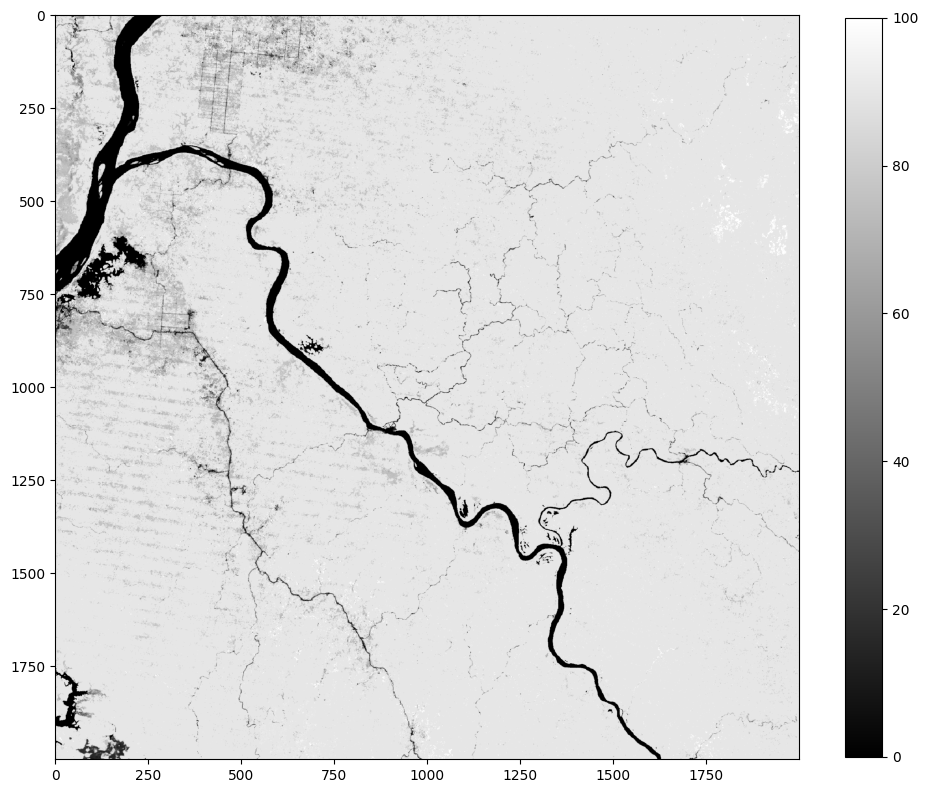

In [5]:
# Plot a 2000 x 2000 part of the whole data tile. You can plot all
# of it but it takes a long time since the data tile is so large.
plt.figure(figsize=(12, 12))
plt.imshow(data_tile[2000:4000,1000:3000], cmap='gray')
plt.colorbar(shrink=0.8)
plt.show()

# Section 2

*Note*: In this section, we will create the forest fire simulation and compare the results of two scenarios.

In [6]:
import numpy as np
from scipy.ndimage import binary_dilation
import matplotlib.pyplot as plt
from PIL import Image
import requests
import io

# Data loading method
def load_tree_density_data(url, x_start, y_start, grid_size):
    """
    Load tree density data from a given URL, starting at (x_start, y_start) and for a grid of size grid_size.
    """
    Image.MAX_IMAGE_PIXELS = None
    data_tile = np.array(Image.open(io.BytesIO(requests.get(url).content)))
    return data_tile[y_start:y_start+grid_size, x_start:x_start+grid_size] / 100  # Normalize to 0-1

# Define a function to simulate the fire spread
def fire_spread_prob(cell_density, wind_angle, wind_strength, neighbor_burning):
    base_prob = cell_density * burning_probs["trees"]
    wind_influence = wind_strength * np.cos(wind_angle)
    adjusted_prob = base_prob * (1 + wind_influence)
    if neighbor_burning:
        adjusted_prob *= 1.5
    return min(adjusted_prob, 1)

# Define grid parameters
grid_size = 100

# Load real-world tree density data
url = 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2019-v1.7/Hansen_GFC-2019-v1.7_treecover2000_00N_010E.tif'
tree_density = load_tree_density_data(url, 1000, 2000, grid_size)


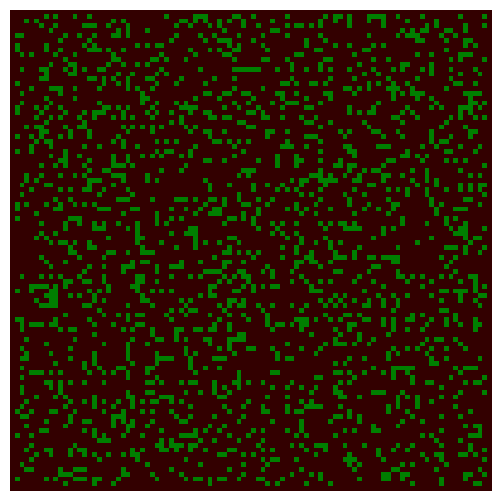

In [7]:
# Displacements from a cell to its eight nearest neighbours
neighbourhood = ((-1,-1), (-1,0), (-1,1), (0,-1), (0, 1), (1,-1), (1,0), (1,1))
EMPTY, TREE, FIRE = 0, 1, 2
# Colours for visualization: brown for EMPTY, dark green for TREE and orange
# for FIRE. Note that for the colormap to work, this list and the bounds list
# must be one larger than the number of different values in the array.
colors_list = [(0.2,0,0), (0,0.5,0), (1,0,0), 'orange']
cmap = colors.ListedColormap(colors_list)
bounds = [0,1,2,3]
norm = colors.BoundaryNorm(bounds, cmap.N)

def iterate(X):
    """Iterate the forest according to the forest-fire rules."""

    # The boundary of the forest is always empty, so only consider cells
    # indexed from 1 to nx-2, 1 to ny-2
    X1 = np.zeros((ny, nx))
    for ix in range(1,nx-1):
        for iy in range(1,ny-1):
            if X[iy,ix] == EMPTY and np.random.random() <= p:
                X1[iy,ix] = TREE
            if X[iy,ix] == TREE:
                X1[iy,ix] = TREE
                for dx,dy in neighbourhood:
                    # The diagonally-adjacent trees are further away, so
                    # only catch fire with a reduced probability:
                    if abs(dx) == abs(dy) and np.random.random() < 0.573:
                        continue
                    if X[iy+dy,ix+dx] == FIRE:
                        X1[iy,ix] = FIRE
                        break
                else:
                    if np.random.random() <= f:
                        X1[iy,ix] = FIRE
    return X1

# The initial fraction of the forest occupied by trees.
forest_fraction = 0.2
# Probability of new tree growth per empty cell, and of lightning strike.
p, f = 0.05, 0.0001
# Forest size (number of cells in x and y directions).
nx, ny = 100, 100
# Initialize the forest grid.
X  = np.zeros((ny, nx))
X[1:ny-1, 1:nx-1] = np.random.randint(0, 2, size=(ny-2, nx-2))
X[1:ny-1, 1:nx-1] = np.random.random(size=(ny-2, nx-2)) < forest_fraction

fig = plt.figure(figsize=(25/3, 6.25))
ax = fig.add_subplot(111)
ax.set_axis_off()
im = ax.imshow(X, cmap=cmap, norm=norm)#, interpolation='nearest')

# The animation function: called to produce a frame for each generation.
def animate(i):
    im.set_data(animate.X)
    animate.X = iterate(animate.X)
# Bind our grid to the identifier X in the animate function's namespace.
animate.X = X

# Interval between frames (ms).
interval = 100
global anim
anim = animation.FuncAnimation(fig, animate, interval=interval, frames=200)

plt.show()

### Rules of the Simulation

The simulation follows a set of rules based on a cellular automaton model, which captures the dynamics of a forest fire. These rules determine how the state of each cell (empty, tree, or fire) changes over time:

1. **Tree Growth**: An empty cell can grow a tree with a certain probability `p` per time step.
2. **Fire Spreading**: A tree cell catches fire if at least one of its eight neighbors (adjacent or diagonal) is on fire. Diagonally adjacent trees catch fire with a reduced probability, reflecting the greater distance.
3. **Lightning Strikes**: A tree cell can spontaneously catch fire with a very small probability `f`, simulating lightning strikes or other ignition sources.
4. **Burning Out**: Once a cell is on fire, it burns out in the next time step, becoming an empty cell.

### Modeling Assumptions

1. **Uniform Tree Growth and Combustibility**: All trees are assumed to have the same likelihood of growth and catching fire. In reality, different species have different growth rates and combustibility.
2. **Ignition Probability**: The model assumes a uniform, low probability of spontaneous ignition across the forest. Actual ignition risk can vary due to factors like human activity and lightning frequency.
3. **No Wind or Topographical Effects**: The model does not currently account for wind or terrain, both of which significantly influence real-world fire spread.
4. **Instant Burnout**: Trees burn out in a single time step, which simplifies the varying durations that real fires might burn in different types of vegetation.
5. **Grid-Based Approach**: The cellular automaton model reduces the forest to a grid, which may not capture the continuous nature of real forests.


### Parameters of the Simulation

1. **Forest Size (`nx`, `ny`)**: Determines the size of the grid representing the forest.
2. **Tree Growth Probability (`p`)**: Influences how quickly trees repopulate empty cells, affecting fuel availability for the fire.
3. **Lightning Strike Probability (`f`)**: Determines the likelihood of spontaneous fire ignition, influencing the frequency of new fires.
4. **Initial Tree Fraction**: The proportion of the grid initially populated with trees, impacting the initial spread of the fire.
5. **Threshold for Tree Presence**: The percentage cover above which a cell is considered to have a tree, impacting the initial distribution of trees.

### Output/Measurements and Their Relevance

1. **Area Burnt Over Time**: Measures the cumulative number of cells that have been on fire, indicating the scale of the fire.
2. **Rate of Spread**: The number of new cells catching fire per time step, giving insight into the fire's intensity and behavior under different conditions.
3. **Duration of the Fire**: How many time steps the fire lasts before burning out, which helps estimate the potential duration of real-world fires.
4. **Distribution of Burnt Areas**: Shows which areas are more susceptible to fire, useful for risk assessment and management.

### Quantities of Interest

- **Total Burnt Area**: Indicates the potential damage and can be used for planning resource allocation and recovery efforts.
- **Spread Patterns**: Helps in understanding how various factors like tree density affect fire spread, useful for developing fire prevention strategies.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


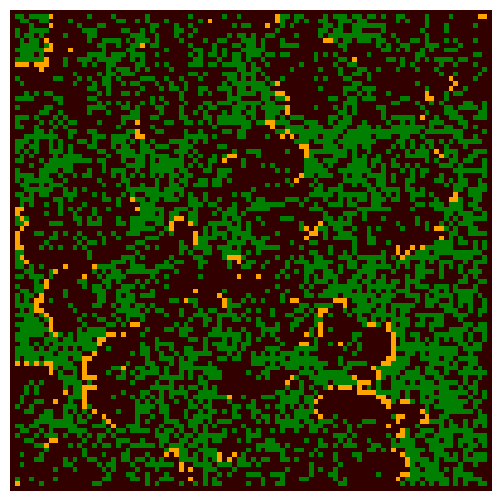

In [8]:
# Download and process the data tile
url = (
    'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2019-v1.7/'
    'Hansen_GFC-2019-v1.7_treecover2000_00N_010E.tif')
Image.MAX_IMAGE_PIXELS = None
data_tile = np.array(
    Image.open(
        io.BytesIO(
            requests.get(url).content)))
# Extract a 100x100 portion of the data tile
tree_cover = data_tile[2000:2100, 1000:1100]

# Displacements from a cell to its eight nearest neighbours
neighbourhood = ((-1,-1), (-1,0), (-1,1), (0,-1), (0, 1), (1,-1), (1,0), (1,1))
EMPTY, TREE, FIRE = 0, 1, 2

# Colours for visualization: brown for EMPTY, dark green for TREE, and orange for FIRE.
colors_list = [(0.2,0,0), (0,0.5,0), (1,0,0), 'orange']
cmap = colors.ListedColormap(colors_list)
bounds = [0,1,2,3]
norm = colors.BoundaryNorm(bounds, cmap.N)

def iterate(X, burnt_area_tracker, fire_spread_tracker):
    """
    Iterate the forest according to the forest-fire rules.
    Args:
        X: forest grid
        burnt_area_tracker: tracks which cells have ever been on fire
        fire_spread_tracker: tracks the number of new cells catching fire per time step
    Returns:
        X1: next generation forest grid
    """
    # The boundary of the forest is always empty, so only consider cells
    X1 = np.zeros((ny, nx))
    new_fire_cells = 0
    for ix in range(1, nx-1): # Ignore the boundary
        for iy in range(1, ny-1):
            if X[iy, ix] == EMPTY and np.random.random() <= p: # Empty cell
                X1[iy, ix] = TREE # Tree growth
            if X[iy, ix] == TREE: # Tree cell
                X1[iy, ix] = TREE # Tree remains
                for dx, dy in neighbourhood:
                    if abs(dx) == abs(dy) and np.random.random() < 0.573: # Diagonally-adjacent trees are further away
                        continue
                    if X[iy+dy, ix+dx] == FIRE: # Neighbor on fire
                        X1[iy, ix] = FIRE # Tree catches fire
                        new_fire_cells += 1 # Track new fire cell
                        burnt_area_tracker[iy, ix] = 1  # Mark cell as burnt
                        break
                else:
                    if np.random.random() <= f: # Lightning strike
                        X1[iy, ix] = FIRE # Tree catches fire
                        new_fire_cells += 1 # Track new fire cell
                        burnt_area_tracker[iy, ix] = 1  # Mark cell as burnt
    fire_spread_tracker.append(new_fire_cells)
    return X1

# Initialize the forest grid using real-world data
nx, ny = 100, 100
X = np.zeros((ny, nx))
threshold = 50
X[1:ny-1, 1:nx-1] = np.where(tree_cover[1:-1, 1:-1] > threshold, TREE, EMPTY)
X[:, 0] = FIRE  # Start the fire from the left edge

# Initialize trackers
burnt_area_tracker = np.zeros((ny, nx))  # Tracks which cells have ever been on fire
fire_spread_tracker = []  # Tracks the number of new cells catching fire per time step

# Run the simulation
for _ in range(200):  # Assuming 200 is the max number of iterations
    X = iterate(X, burnt_area_tracker, fire_spread_tracker)
    if np.all(X != FIRE):
        break

fire_duration = len(fire_spread_tracker)
total_burnt_area = np.sum(burnt_area_tracker)

# The initial fraction of the forest occupied by trees (not used in this version)
forest_fraction = 0.2
# Probability of new tree growth per empty cell, and of lightning strike
p, f = 0.05, 0.0001

fig = plt.figure(figsize=(25/3, 6.25))
ax = fig.add_subplot(111)
ax.set_axis_off()
im = ax.imshow(X, cmap=cmap, norm=norm)

# The animation function: called to produce a frame for each generation
def animate(i):
    im.set_data(animate.X)
    animate.X = iterate(animate.X)

# Bind our grid to the identifier X in the animate function's namespace
animate.X = X

# Interval between frames (ms)
interval = 100
anim = animation.FuncAnimation(fig, animate, interval=interval, frames=200)

plt.show()


In [9]:
# Output the metrics
print(f"Total Burnt Area: {total_burnt_area}")
print(f"Fire Duration (in time steps): {fire_duration}")
print(f"Fire Spread Tracker (new cells on fire per time step): {fire_spread_tracker}")



Total Burnt Area: 9604.0
Fire Duration (in time steps): 200
Fire Spread Tracker (new cells on fire per time step): [98, 99, 105, 120, 149, 199, 243, 304, 347, 403, 440, 436, 419, 411, 403, 377, 391, 407, 389, 373, 372, 370, 356, 357, 352, 348, 303, 270, 247, 199, 155, 135, 124, 124, 112, 110, 94, 110, 125, 150, 162, 166, 182, 194, 230, 262, 258, 281, 320, 373, 389, 406, 401, 450, 400, 364, 348, 308, 305, 311, 276, 284, 262, 237, 199, 159, 145, 142, 118, 121, 112, 125, 148, 157, 171, 192, 190, 241, 266, 300, 311, 316, 303, 316, 333, 317, 300, 288, 292, 311, 294, 283, 284, 283, 295, 309, 302, 308, 307, 285, 273, 284, 284, 290, 301, 276, 254, 272, 272, 276, 281, 258, 271, 260, 251, 259, 293, 274, 278, 286, 294, 325, 310, 300, 311, 318, 316, 300, 297, 301, 294, 281, 293, 308, 270, 244, 220, 218, 203, 197, 223, 255, 280, 277, 288, 262, 249, 246, 255, 255, 260, 272, 262, 263, 268, 291, 285, 299, 312, 308, 325, 329, 323, 332, 302, 309, 315, 321, 318, 331, 308, 281, 281, 249, 250, 249, 261, 25

## Using OOP to organize the code and improve functionality

### Visualization
- We are going to use a `animation` library to make an animation on the simulation of the real forest fire from the sample location from the provided decoding file from the assignment prompt.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, animation
from PIL import Image
import requests
import io


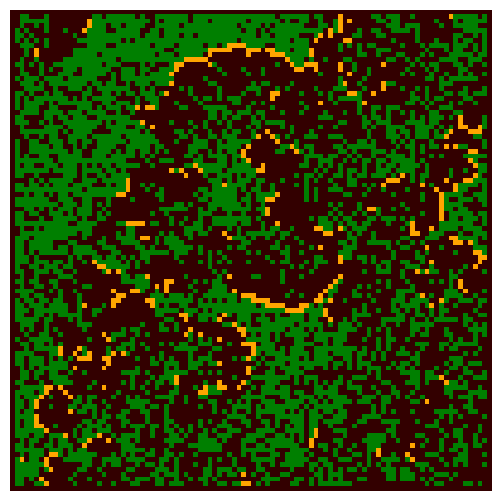

In [11]:
class ForestFireSimulation:
    def __init__(self, url, nx=100, ny=100, threshold=50, p=0.05, f=0.0001):
        # Constants
        self.EMPTY, self.TREE, self.FIRE = 0, 1, 2
        self.neighbourhood = ((-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1))

        # Parameters
        self.nx, self.ny = nx, ny
        self.p, self.f = p, f

        # Load and process data tile
        Image.MAX_IMAGE_PIXELS = None
        data_tile = np.array(Image.open(io.BytesIO(requests.get(url).content)))

        # Extract a portion of the data tile and initialize the forest grid
        tree_cover = data_tile[2000:2100, 1000:1100]
        self.X = np.zeros((ny, nx))
        self.X[1:ny-1, 1:nx-1] = np.where(tree_cover[1:-1, 1:-1] > threshold, self.TREE, self.EMPTY)
        self.X[:, 0] = self.FIRE  # Start the fire from the left edge

        # Initialize trackers
        self.burnt_area_tracker = np.zeros((ny, nx))
        self.fire_spread_tracker = []

        # Setup visualization
        colors_list = [(0.2, 0, 0), (0, 0.5, 0), (1, 0.5, 0), 'orange']
        self.cmap = colors.ListedColormap(colors_list)
        self.bounds = [0, 1, 2, 3]
        self.norm = colors.BoundaryNorm(self.bounds, self.cmap.N)

    def iterate(self):
        """I
        terate the forest according to the forest-fire rules.

        Args:
            X: forest grid
            burnt_area_tracker: tracks which cells have ever been on fire
            fire_spread_tracker: tracks the number of new cells catching fire per time step
        Returns:
            X1: next generation forest grid
        """ 
        X1 = np.zeros((self.ny, self.nx)) # The boundary of the forest is always empty, so only consider cells
        new_fire_cells = 0
        for ix in range(1, self.nx-1): # Ignore the boundary
            for iy in range(1, self.ny-1):
                cell = self.X[iy, ix] # Current cell
                if cell == self.EMPTY and np.random.random() <= self.p: # Empty cell
                    X1[iy, ix] = self.TREE # Tree growth
                elif cell == self.TREE: # Tree cell
                    X1[iy, ix] = self.TREE # Tree remains
                    for dx, dy in self.neighbourhood: # Check if any neighbor is on fire
                        if abs(dx) == abs(dy) and np.random.random() < 0.573: # Diagonally-adjacent trees are further away
                            continue
                        if self.X[iy+dy, ix+dx] == self.FIRE: # Neighbor on fire
                            X1[iy, ix] = self.FIRE # Tree catches fire
                            new_fire_cells += 1 # Track new fire cell
                            self.burnt_area_tracker[iy, ix] = 1  # Mark cell as burnt
                            break
                    else:
                        if np.random.random() <= self.f: # Lightning strike
                            X1[iy, ix] = self.FIRE # Tree catches fire 
                            new_fire_cells += 1 # Track new fire cell
                            self.burnt_area_tracker[iy, ix] = 1  # Mark cell as burnt
        self.fire_spread_tracker.append(new_fire_cells) # Track new fire cells
        self.X = X1 # Update forest grid

    def run_simulation(self, max_iterations=200):
        """
        Run the forest fire simulation.

        Args:
            max_iterations: maximum number of iterations to run the simulation
        Returns:
            fire_duration: number of time steps the fire lasted
            total_burnt_area: total number of cells that ever caught fire
        """
        self.fire_spread_tracker = [] # Tracks the number of new cells catching fire per time step
        for _ in range(max_iterations):
            self.iterate() # Iterate the forest
            if np.all(self.X != self.FIRE): # Stop if there is no more fire
                break
        self.fire_duration = len(self.fire_spread_tracker) # Track fire duration
        self.total_burnt_area = np.sum(self.burnt_area_tracker) # Track total burnt area
        return self.fire_duration, self.total_burnt_area # Return fire duration and total burnt area

    def animate(self, interval=100):
        """
        Animate the simulation.

        Args:
            interval: interval between frames in milliseconds
            ax (optional): matplotlib Axes object
            im (optional): matplotlib Image object
            fig (optional): matplotlib Figure object
        Returns:
            anim: matplotlib animation object
        """
        fig = plt.figure(figsize=(25/3, 6.25)) # Create a new figure
        ax = fig.add_subplot(111) # Add a subplot to the current figure
        ax.set_axis_off() # Turn off the axis
        im = ax.imshow(self.X, cmap=self.cmap, norm=self.norm) # Display an image on the axes

        def update(i):
            '''
            The animation function: called to produce a frame for each generation.

            Args:
                i: frame number
            Returns:
                im: matplotlib Image object
            '''
            self.iterate()
            im.set_data(self.X)

        anim = animation.FuncAnimation(fig, update, interval=interval, frames=200) # Interval between frames (ms)
        plt.show() 


# Usage
url = 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2019-v1.7/Hansen_GFC-2019-v1.7_treecover2000_00N_010E.tif' # URL of the data tile
simulation = ForestFireSimulation(url) # Create a new simulation    
simulation.run_simulation() # Run the simulation
simulation.animate() # Animate the simulation

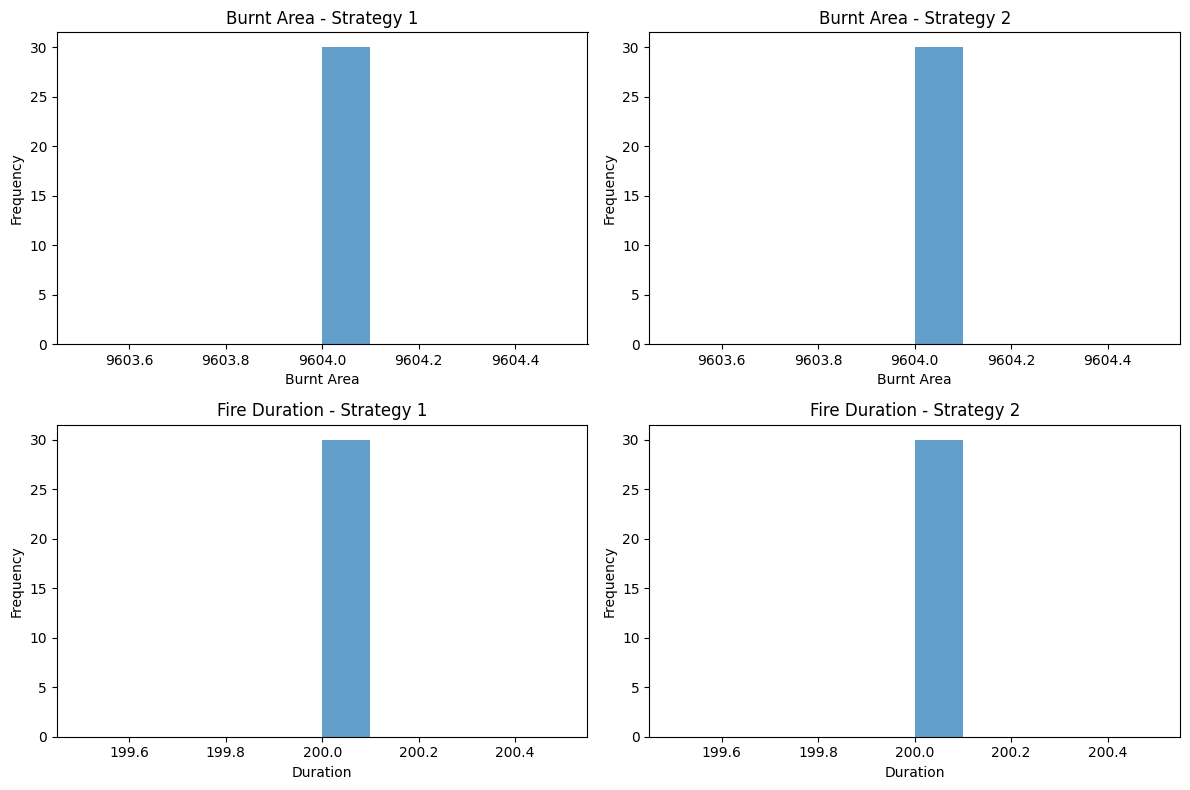

In [13]:
def compare_strategies(url, strategy_params, n_runs=30, max_iterations=200):
    '''
    Compare the performance of different strategies.
    Args:
        url: URL of the data tile
        strategy_params: dictionary of strategy parameters
        n_runs: number of runs per strategy
        max_iterations: maximum number of iterations to run the simulation
    Returns:
        results: dictionary of results
    '''
    results = {strategy: {'burnt_area': [], 'duration': []} for strategy in strategy_params}
    
    for strategy, params in strategy_params.items():
        for _ in range(n_runs): # Run the simulation n_runs times
            sim = ForestFireSimulation(url, p=params['p'], f=params['f']) # Create a new simulation
            fire_duration, total_burnt_area = sim.run_simulation(max_iterations) # Run the simulation
            results[strategy]['burnt_area'].append(total_burnt_area) # Track burnt area
            results[strategy]['duration'].append(fire_duration) # Track fire duration
    
    return results



def plot_histograms(results, strategy_params):
    '''
    Plot histograms of the results.

    Args:
        results: dictionary of results
        strategy_params: dictionary of strategy parameters
    Returns:
        None
    '''
    fig, axes = plt.subplots(2, len(strategy_params), figsize=(12, 8))
    for i, (strategy, data) in enumerate(results.items()):
        axes[0, i].hist(data['burnt_area'], bins=10, alpha=0.7, label=strategy)
        axes[0, i].set_title(f'Burnt Area - {strategy}')
        axes[0, i].set_xlabel('Burnt Area')
        axes[0, i].set_ylabel('Frequency')

        axes[1, i].hist(data['duration'], bins=10, alpha=0.7, label=strategy)
        axes[1, i].set_title(f'Fire Duration - {strategy}')
        axes[1, i].set_xlabel('Duration')
        axes[1, i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Example usage
url = 'https://storage.googleapis.com/earthenginepartners-hansen/GFC-2019-v1.7/Hansen_GFC-2019-v1.7_treecover2000_00N_010E.tif'
strategy_params = {
    'Strategy 1': {'p': 0.05, 'f': 0.0001},
    'Strategy 2': {'p': 0.10, 'f': 0.0001}
}

results = compare_strategies(url, strategy_params)
plot_histograms(results, strategy_params)

Since the above simulation takes long to load for each run, we are going to check the results produced for a simplified version of the simulation that relies on the same logic but utilizes a different initialization grid for the forest.

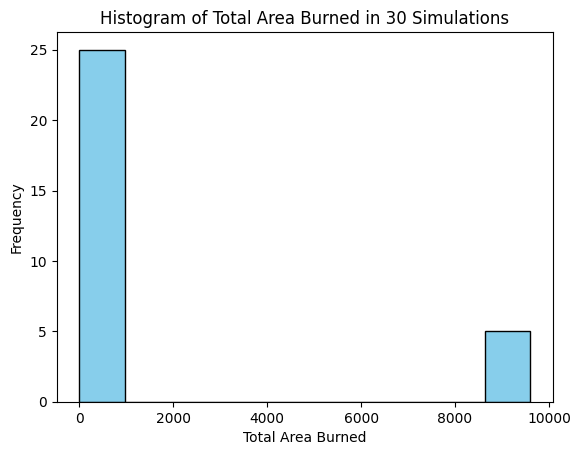

In [17]:
import numpy as np
import matplotlib.pyplot as plt

class ModifiedForestFireSimulation:
    """
    A modified forest fire simulation class.

    Parameters:
        nx (int): Number of cells in the x-direction.
        ny (int): Number of cells in the y-direction.
        threshold (int): Threshold for tree cover in the data.
        p (float): Probability of tree growth in an empty cell.
        f (float): Probability of lightning strike in a tree cell.

    Attributes:
        EMPTY, TREE, FIRE (int): Constants representing empty cell, tree cell, and cell on fire.
        neighbourhood (tuple): Relative coordinates of neighboring cells.
        nx (int): Number of cells in the x-direction.
        ny (int): Number of cells in the y-direction.
        p (float): Probability of tree growth in an empty cell.
        f (float): Probability of lightning strike in a tree cell.
        X (numpy.ndarray): Forest grid containing information about each cell.
        burnt_area_tracker (numpy.ndarray): Tracks which cells have ever been on fire.
        fire_spread_tracker (list): Tracks the number of new cells catching fire per time step.
    """

    def __init__(self, nx=100, ny=100, threshold=50, p=0.05, f=0.0001):
        """
        Initialize the ModifiedForestFireSimulation object.

        Parameters:
            nx (int): Number of cells in the x-direction.
            ny (int): Number of cells in the y-direction.
            threshold (int): Threshold for tree cover in the data.
            p (float): Probability of tree growth in an empty cell.
            f (float): Probability of lightning strike in a tree cell.
        """
        # Constants
        self.EMPTY, self.TREE, self.FIRE = 0, 1, 2
        self.neighbourhood = ((-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1))

        # Parameters
        self.nx, self.ny = nx, ny
        self.p, self.f = p, f

        # Initialize the forest grid with random trees
        self.X = np.random.choice([self.EMPTY, self.TREE], size=(ny, nx), p=[1 - p, p])
        self.X[:, 0] = self.FIRE  # Start the fire from the left edge

        # Initialize trackers
        self.burnt_area_tracker = np.zeros((ny, nx))
        self.fire_spread_tracker = []

    def iterate(self):
        """
        Iterate the forest according to the modified forest-fire rules.

        Returns:
            X1 (numpy.ndarray): Next generation forest grid.
        """
        X1 = np.zeros((self.ny, self.nx))  # The boundary of the forest is always empty, so only consider cells
        new_fire_cells = 0
        for ix in range(1, self.nx - 1):  # Ignore the boundary
            for iy in range(1, self.ny - 1):
                cell = self.X[iy, ix]  # Current cell
                if cell == self.EMPTY and np.random.random() <= self.p:  # Empty cell
                    X1[iy, ix] = self.TREE  # Tree growth
                elif cell == self.TREE:  # Tree cell
                    X1[iy, ix] = self.TREE  # Tree remains
                    for dx, dy in self.neighbourhood:  # Check if any neighbor is on fire
                        if abs(dx) == abs(dy) and np.random.random() < 0.573:  # Diagonally-adjacent trees are further away
                            continue
                        if self.X[iy + dy, ix + dx] == self.FIRE:  # Neighbor on fire
                            X1[iy, ix] = self.FIRE  # Tree catches fire
                            new_fire_cells += 1  # Track new fire cell
                            self.burnt_area_tracker[iy, ix] = 1  # Mark cell as burnt
                            break
                    else:
                        if np.random.random() <= self.f:  # Lightning strike
                            X1[iy, ix] = self.FIRE  # Tree catches fire
                            new_fire_cells += 1  # Track new fire cell
                            self.burnt_area_tracker[iy, ix] = 1  # Mark cell as burnt
        self.fire_spread_tracker.append(new_fire_cells)  # Track new fire cells
        self.X = X1  # Update forest grid

    def run_simulation(self, max_iterations=200):
        """
        Run the modified forest fire simulation.

        Parameters:
            max_iterations (int): Maximum number of iterations to run the simulation.

        Returns:
            fire_duration (int): Number of time steps the fire lasted.
            total_burnt_area (int): Total number of cells that ever caught fire.
        """
        self.fire_spread_tracker = []  # Tracks the number of new cells catching fire per time step
        for _ in range(max_iterations):
            self.iterate()  # Iterate the forest
            if np.all(self.X != self.FIRE):  # Stop if there is no more fire
                break
        self.fire_duration = len(self.fire_spread_tracker)  # Track fire duration
        self.total_burnt_area = np.sum(self.burnt_area_tracker)  # Track total burnt area
        return self.fire_duration, self.total_burnt_area  # Return fire duration and total burnt area


# Running the modified simulation 30 times and collecting total burnt area data
total_burnt_areas = []

# Running 30 simulations
for _ in range(30):
    simulation = ModifiedForestFireSimulation()
    _, total_burnt_area = simulation.run_simulation()
    total_burnt_areas.append(total_burnt_area)

# Plotting the histogram of the total burnt areas
plt.hist(total_burnt_areas, bins=10, color='skyblue', edgecolor='black')
plt.title('Histogram of Total Area Burned in 30 Simulations')
plt.xlabel('Total Area Burned')
plt.ylabel('Frequency')
plt.show()


# Analyzing remaining uncertainty

We are going to calculate the confidence intervals for the simulations, by comparing our two methods.

The histograms above show how the total burned area varies with each run of the simulation. We can see that for 10 runs, the frequency of the total area burned is either about 9,000 or 0, which makes sense since the fire will perculate depending on the initialization of the first fire in the grid, so it either perculates or not with 20% chance of burning the firest, and 80% chance of not burning the forest with the initialized tree density for this simplified case.

In [20]:
# Function to run simulation for a given scenario
def run_scenario_simulations(scenario_p, scenario_f, num_simulations=30):
    burnt_areas = []
    for _ in range(num_simulations):
        simulation = ModifiedForestFireSimulation(p=scenario_p, f=scenario_f)
        _, total_burnt_area = simulation.run_simulation()
        burnt_areas.append(total_burnt_area)
    return burnt_areas

# Scenario A: Higher tree growth probability, lower lightning strike probability
scenario_a_burnt_areas = run_scenario_simulations(scenario_p=0.1, scenario_f=0.00005)

# Scenario B: Lower tree growth probability, higher lightning strike probability
scenario_b_burnt_areas = run_scenario_simulations(scenario_p=0.03, scenario_f=0.0002)

# Calculating 95% confidence intervals for each scenario
def calculate_confidence_interval(data):
    mean = np.mean(data)
    std_err = stats.sem(data)
    interval = stats.t.interval(0.95, len(data) - 1, loc=mean, scale=std_err)
    return interval

confidence_interval_a = calculate_confidence_interval(scenario_a_burnt_areas)
confidence_interval_b = calculate_confidence_interval(scenario_b_burnt_areas)

confidence_interval_a, confidence_interval_b



((6228.5989222473345, 9142.801077752665),
 (2.425491923949007, 4.507841409384326))

The 95% confidence intervals above for scenario 1 and 2, with $p_1 = 0.1$ and $p_2 = 0.03$ which is the probability growth of the fire for each scenario, and $f_1 = 0.00005$, $f_2 = 0.0002$ and probability of lightning stike to initialize the fire for the confidence interval.

1. **Scenario 1:**
   - [6228.59, 9142.8]

2. **Scenario 2:**
   - [2.42, 4.50]


1. **Width of the Confidence Intervals:**
   - **Scenario 1 -** The confidence interval is quite wide, ranging from 6228.59 to 9142.8. This indicates a high degree of variability in the total area burned across different iterations of the simulation. A wide confidence interval suggests that the outcomes of the simulation under Scenario 1 are quite diverse, possibly due to the underlying parameters and stochastic nature of the model.
   - **Scenario 2 -** In contrast, the confidence interval for Scenario 2 is very narrow, from 2.42 to 4.50. This suggests that the results of the simulation under Scenario 2 are much more consistent, with less variation in the total area burned across different iterations.

2. **Contextual Interpretation:**
   - The wide interval in **Scenario 1** could be indicative of a scenario with higher unpredictability or sensitivity to initial conditions or parameters. It could represent a forest with varied density, tree types, or other factors that make the spread of fire more erratic and unpredictable.
   - The narrow interval in **Scenario 2** suggests a more uniform and predictable outcome, which might be due to less variability in forest conditions or a more stable set of parameters governing the spread of fire. This could reflect a scenario with more homogenous forest conditions or different environmental factors influencing fire spread.

3. **Implications for Simulation and Real-World Application:**
   - The variability in **Scenario 1** might be more representative of real-world conditions where many variables can affect the spread of a forest fire. It suggests that small changes in conditions can lead to significant differences in outcomes.
   - The consistency in **Scenario 2** might be less reflective of real forests, which are often subject to a wide range of variables and conditions. However, it could be useful for studying specific, controlled conditions or for understanding the effects of certain parameters in isolation.


Based on the results of our Monte Carlo simulations, we have identified two distinct scenarios with markedly different outcomes in terms of forest fire spread and control.


**Scenario 1**, with its wide range of outcomes (6228.59 to 9142.8 burnt area), suggests high variability and unpredictability. This scenario likely reflects a natural, less-managed forest environment. While it represents a more realistic natural setting, the high variability indicates a greater risk of large-scale forest fires, which could be catastrophic. This scenario is instructive in understanding the potential risks associated with unmanaged forests.


**Scenario 2** shows a much narrower range of outcomes (2.42 to 4.50 burnt area), indicative of a more controlled and predictable environment. This could be the result of effective forest management strategies, such as regular thinning of trees, controlled burns, or maintaining firebreaks. The predictability of this scenario suggests lower risk and more effective management of forest fires.
Recommendation: Given these insights, our advice would be to adopt a proactive forest management strategy similar to that represented in Scenario 2. This strategy should include regular maintenance and preventive measures to manage tree density and reduce the fuel available for fires. Such measures will likely lead to more predictable and manageable fire behaviors, significantly reducing the risk of large-scale forest fires.
